# 평가 지표 구현 (230110)

In [16]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(42)
device = torch.device("cuda" if use_cuda else "cpu")

In [18]:
class DNN(nn.Module):
  def __init__(self):
    super(DNN, self).__init__() # 자식클래스가 상속받는 부모 클래스를 불러옴
    self.fc1 = nn.Linear(784, 500)  # input = 28 * 28 * 1 = 784
    self.fc2 = nn.Linear(500, 1000)
    self.fc3 = nn.Linear(1000, 10)  # output = 10 (라벨 개수)

  def forward(self, x):
    x = x.view(-1, 784) # flatten: 1차원
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x) # classification의 출력층이므로 relu X
    return F.log_softmax(x, dim=1)

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5)  # input channel, ouput channel, kernel
    self.conv2 = nn.Conv2d(20, 50, 5)
    self.fc1 = nn.Linear(4*4*50, 500)  # input 아님. 계산하기
    self.fc2 = nn.Linear(500, 10)  # output = 10 (라벨 개수)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4 * 4 * 50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x) # classification의 출력층이므로 relu X
    return F.log_softmax(x, dim=1)


In [19]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=1000, shuffle=True
)

In [20]:
test_image = test_loader.dataset.data
test_image.shape

torch.Size([10000, 28, 28])

error:

> can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

주의사항:

> + extend (O)
> + append (X)

test_loader는 10번의 iteration (한 번의 iteration = 1000개의 데이터)을 돔. 그 결과, extend와 append의 결과는 서로 다름. 목적에 맞게 1차원으로 만들기 위해 extend를 사용해야함.

DNN's Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CNN's Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.9

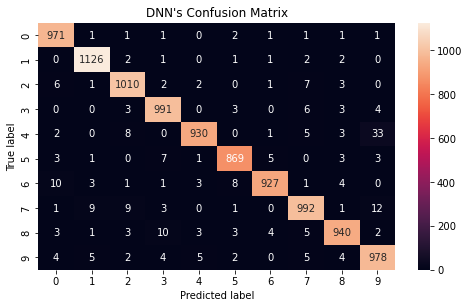

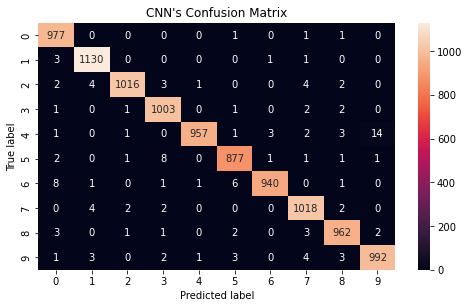

In [21]:
idx = 1
for model_type in [DNN, CNN]:
  y_true = []
  y_pred = []

  # 모델 불러오기
  model = model_type().to(device)
  model.load_state_dict(torch.load("mnist_" + type(model).__name__ + ".pt"))
  model.eval()
  
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    
    # extend : append 하면 안 됨. 1000개 * 10번 iteration -> 행렬이  1000 * 10이 됨.
    out = model(data.float().cuda())
    y_pred.extend(out.argmax(dim=1).data.cpu().numpy())
    y_true.extend(target.data.cpu().numpy())

  metric = confusion_matrix(y_true, y_pred)
  df = pd.DataFrame(metric, index = [i for i in range(10)], columns = [i for i in range(10)])

  # confusion_matrix 시각화
  plt.figure(figsize = (8, 10))
  plt.subplot(2, 1, idx)
  idx += 1
  sns.heatmap(df, annot=True, fmt='d')
  plt.title(type(model).__name__ + "'s Confusion Matrix")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  # classification_report 출력
  print(type(model).__name__ + '\'s Classification Report\n' + classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)]))